In [73]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [74]:
data = []
file_name = []
datalabel = []
path = []
data_distribution = {}

for label in os.listdir("dataset"):
    label_path = os.path.join("dataset", label)
    if not os.path.isdir(label_path):
        continue  # Lewati jika bukan folder
    images = os.listdir(label_path)
    data_distribution[label] = len(images)
    datalabel.append(label)
    print(f"Memproses label: {label}, jumlah gambar: {len(images)}")

    for filename in os.listdir(label_path):
        img_path = os.path.join(label_path, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (350, 350))
            file_name.append(filename)
            path.append(img_path)
            data.append(img)
print("Data: ", len(data))
print("Label: ", len(datalabel))
print("Filenames: ", len(file_name))
print("Data Distribution: ", data_distribution)

Memproses label: fresh, jumlah gambar: 72
Memproses label: spoiled, jumlah gambar: 72
Data:  144
Label:  2
Filenames:  144
Data Distribution:  {'fresh': 72, 'spoiled': 72}


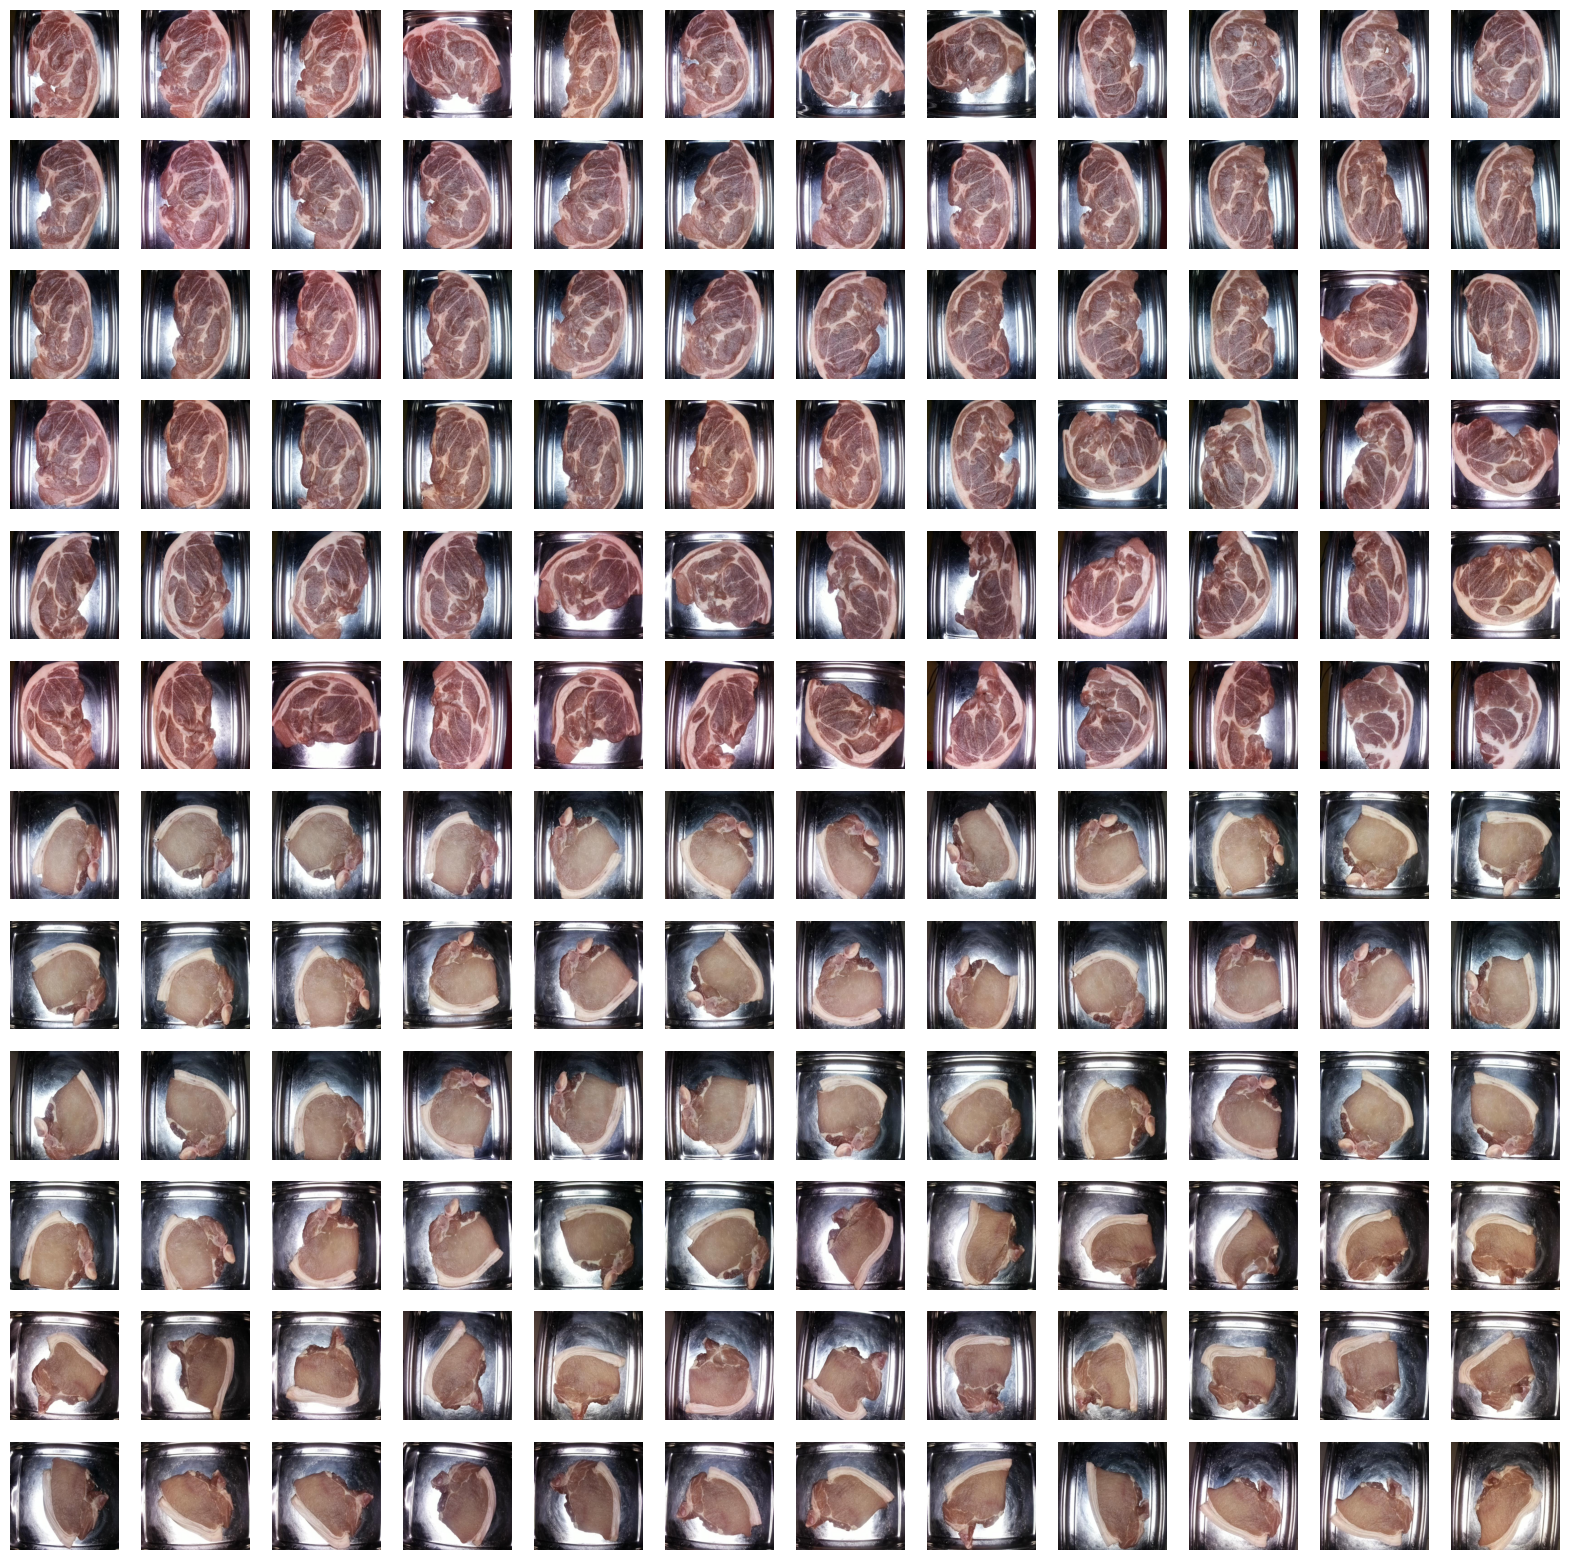

In [75]:
def displayImg(row, column, data):
    fig = plt.figure(figsize=(20, 20))
    for i in range(1, row * column + 1):
        fig.add_subplot(row, column, i)
        plt.imshow(data[i - 1], cmap='gray')
        plt.axis('off')  
    plt.show()
displayImg(12,12, data)

## Data Augmentation

### Define Augmentation Function


In [76]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

def flip_horizontal(image):
    flipped = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            flipped[i, j] = image[i, image.shape[1] - 1 - j]
    return flipped

def rotate(image):
    rotated = np.zeros((image.shape[1], image.shape[0]), dtype=image.dtype)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rotated[j, image.shape[0] - 1 - i] = image[i, j]
    return rotated

for i in range(len(data)):
    flipped = flip_horizontal(data[i])
    rotated = rotate(data[i])

    data_augmented.append(flipped)
    data_augmented.append(rotated)

    labels_augmented.extend([datalabel[i]] * 2)
    file_name_augmented.extend([file_name[i] + '_flip', file_name[i] + '_rot'])


ValueError: setting an array element with a sequence.

In [ ]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  432
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [ ]:
def resize(image, new_width, new_height):
    old_height, old_width = image.shape[:2]
    resized_image = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(j * old_width / new_width)
            y = int(i * old_height / new_height)
            resized_image[i, j] = image[y, x]

    return resized_image

def equalization(image):
    frequent = {}
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            value = image[i, j]
            if value in frequent:
                frequent[value] += 1
            else:
                frequent[value] = 1

    cumuFreq = {}
    sortedKey = sorted(frequent.keys())
    
    total = 0
    for key in sortedKey:
        total += frequent[key]
        cumuFreq[key] = total

    newPixel = {}
    sumAllPixel = image.shape[0] * image.shape[1]
    for key in sortedKey:
        newPixel[key] = round((cumuFreq[key] / sumAllPixel) * 255)

    newImage = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            newImage[i, j] = newPixel[image[i, j]]

    return newImage
    
def sobel(gray):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[ 1,  2,  1],
                        [ 0,  0,  0],
                        [-1, -2, -1]])

    tinggi, lebar = gray.shape
    hasil = np.zeros((tinggi, lebar), dtype=np.float32)

    for i in range(1, tinggi-1):
        for j in range(1, lebar-1):
            region = gray[i-1:i+2, j-1:j+2]
            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)
            hasil[i, j] = np.sqrt(gx**2 + gy**2)

    hasil = np.clip(hasil, 0, 255)
    return hasil.astype(np.uint8)


### Preprocessing

In [ ]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)):
    img = resize(data[i], 128, 128)
    img = equalization(img)
    dataPreprocessed.append(img)


### Feature Extraction

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [ ]:
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]

In [ ]:
def entropyGlcm(matrix):
    glcm_array = matrix[:, :, 0, 0]
    return entropy(glcm_array.flatten())


In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [ ]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [ ]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [ ]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [ ]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [ ]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [ ]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [ ]:
dataTable = {'Filename': file_name, 'Label': datalabel,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


Filename    Label    Contrast0  \
0    08-11-2022-09-29-23_jpg.rf.64d249dc62a73d0ad8a...    fresh  1498.807825   
1    08-11-2022-09-31-38_jpg.rf.a062a431d30171b3151...    fresh  1711.991019   
2    08-11-2022-09-33-12_jpg.rf.b59993e6f78e188270c...    fresh  1694.605007   
3    08-11-2022-09-33-46_jpg.rf.ac147752030f7341361...    fresh   991.528789   
4    08-11-2022-09-38-25_jpg.rf.98422f41a439f4b9caf...    fresh  1427.610052   
..                                                 ...      ...          ...   
139  08-11-2022-22-04-53_jpg.rf.898d4dacb6b481c54a1...  spoiled   646.477731   
140  08-11-2022-22-05-41_jpg.rf.1911a77bc56f9cf0c0d...  spoiled  1230.849409   
141  08-11-2022-22-06-09_jpg.rf.22c8c2df12f95b3ce32...  spoiled  1331.106176   
142  08-11-2022-22-06-15_jpg.rf.a281f03d8553c96d251...  spoiled  1404.222441   
143  08-11-2022-22-06-53_jpg.rf.d12a42faca27d57ba39...  spoiled  1281.910187   

      Contrast45  Contrast90  Contrast135  Homogeneity0  Homogeneity45  \
0    1782.741521  700.603593  1698.687333      0.091816       0.079296   
1    2017.254821  698.424520  1864.753116      0.083625       0.072130   
2    1984.909604  643.456939  1792.919958      0.086544       0.073558   
3    1405.644305  961.824557  1540.295927      0.126868       0.100806   
4    1590.085808  411.220965  1453.391097      0.090685       0.082351   
..           ...         ...          ...           ...            ...   
139  1077.960072  675.281681  1014.863352      0.141513       0.104911   
140  1308.526629  236.028359  1282.218240      0.113732       0.106216   
141  1491.753798  365.908957  1411.005952      0.103234       0.096073   
142  1605.217682  411.205155  1496.311551      0.103247       0.094082   
143  1439.607415  289.390625  1297.742575      0.103645       0.093593   

     Homogeneity90  Homogeneity135  ...     ASM90    ASM135   Energy0  \
0         0.162640        0.079174  ...  0.000364  0.000171  0.013836   
1         0.147446        0.080802  ...  0.000230  0.000126  0.011330   
2         0.148389        0.081781  ...  0.000236  0.000130  0.011603   
3         0.122974        0.092838  ...  0.000443  0.000378  0.022137   
4         0.166114        0.088142  ...  0.000307  0.000161  0.012748   
..             ...             ...  ...       ...       ...       ...   
139       0.136064        0.111758  ...  0.000512  0.000444  0.023533   
140       0.177336        0.095579  ...  0.000471  0.000249  0.016564   
141       0.149404        0.085552  ...  0.000287  0.000158  0.013254   
142       0.146454        0.084469  ...  0.000264  0.000150  0.012929   
143       0.169729        0.101895  ...  0.000487  0.000276  0.016734   

     Energy45  Energy90  Energy135  Correlation0  Correlation45  \
0    0.013066  0.019091   0.013084      0.860699       0.833578   
1    0.010801  0.015178   0.011228      0.841541       0.812669   
2    0.011041  0.015359   0.011410      0.843387       0.816340   
3    0.019834  0.021057   0.019447      0.908280       0.869429   
4    0.012292  0.017520   0.012707      0.868254       0.852899   
..        ...       ...        ...           ...            ...   
139  0.020647  0.022633   0.021076      0.940060       0.900062   
140  0.016249  0.021704   0.015780      0.886125       0.878755   
141  0.012741  0.016931   0.012581      0.877229       0.862038   
142  0.012327  0.016249   0.012261      0.870505       0.851577   
143  0.016017  0.022064   0.016615      0.882049       0.867233   

     Correlation90  Correlation135  
0         0.935067        0.841434  
1         0.935312        0.826826  
2         0.940540        0.834104  
3         0.911072        0.856926  
4         0.961960        0.865545  
..             ...             ...  
139       0.937754        0.905912  
140       0.978098        0.881200  
141       0.966118        0.869516  
142       0.961939        0.861656  
143       0.973281        0.880325  

[144 rows x 30 columns]

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

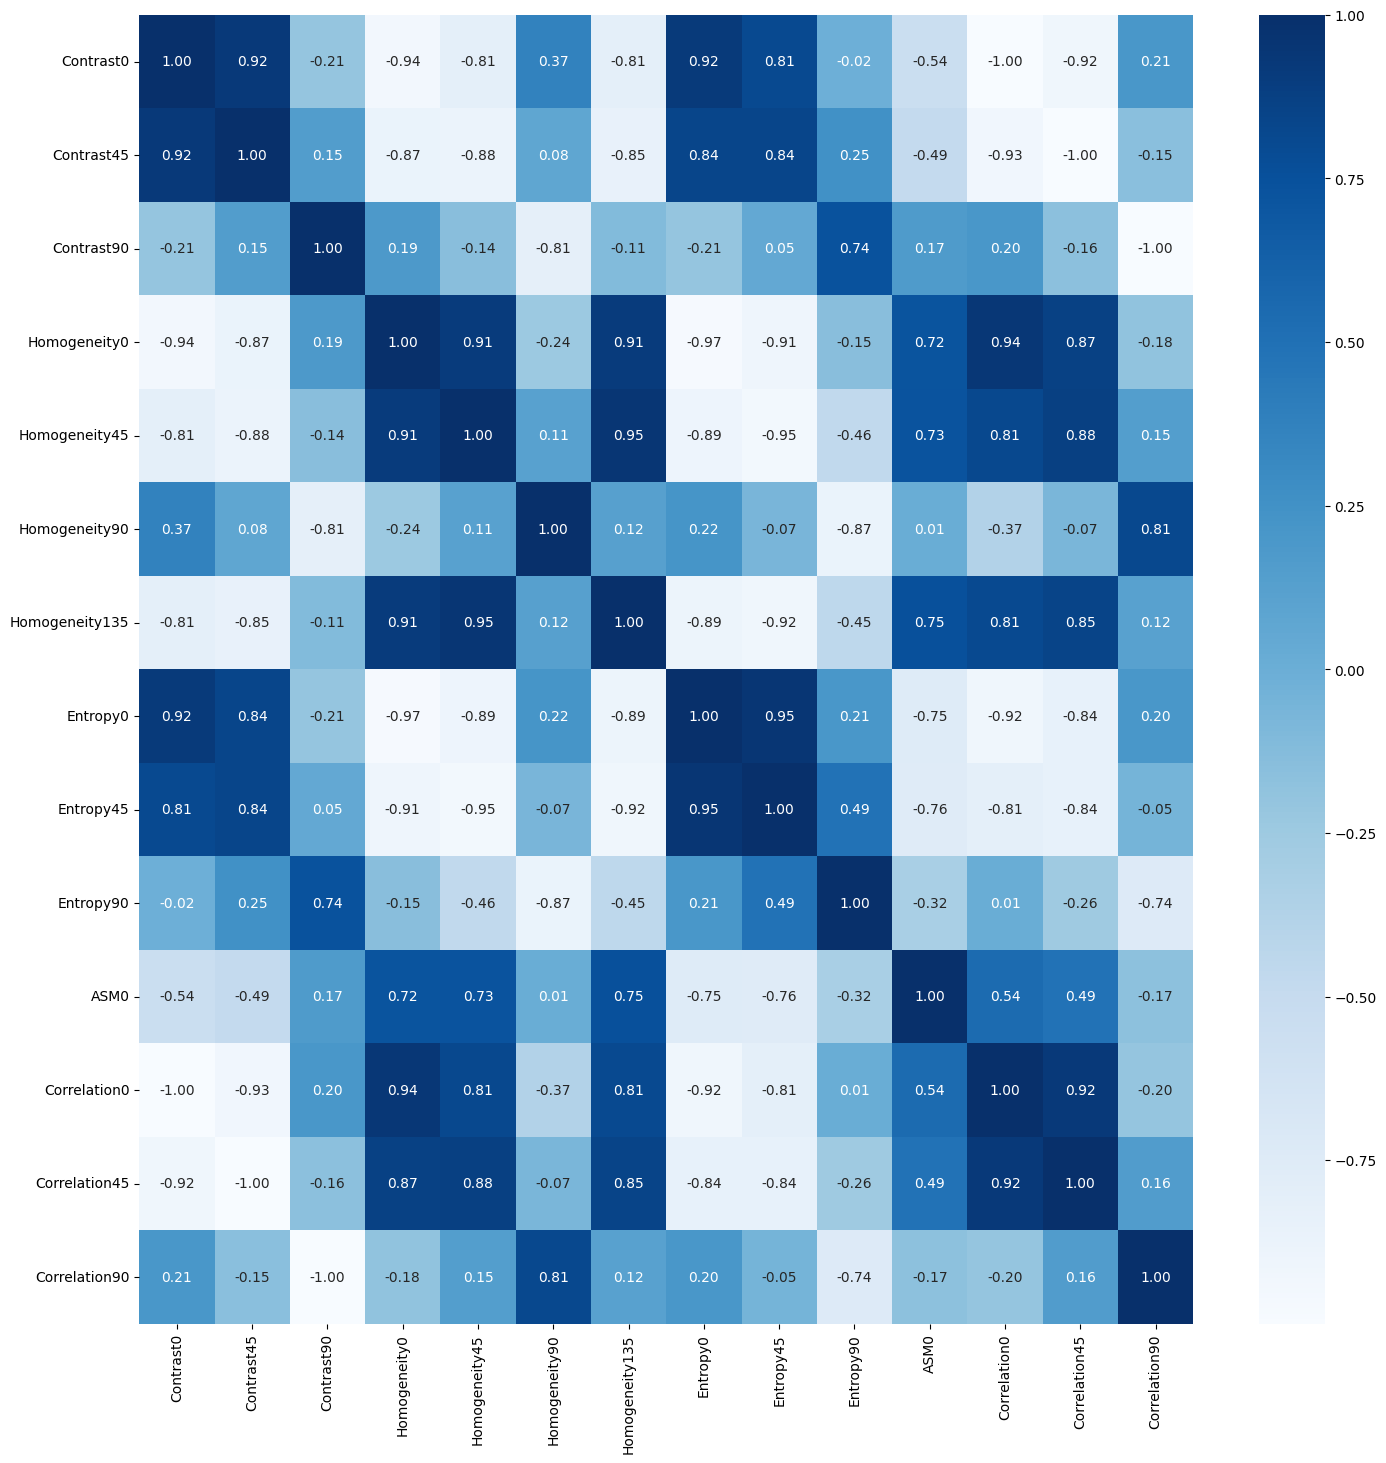

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(115, 14)
(29, 14)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [ ]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       fresh       1.00      0.96      0.98        56
     spoiled       0.97      1.00      0.98        59

    accuracy                           0.98       115
   macro avg       0.98      0.98      0.98       115
weighted avg       0.98      0.98      0.98       115

[[54  2]
 [ 0 59]]
Accuracy: 0.9826086956521739

------Testing Set------
              precision    recall  f1-score   support

       fresh       0.92      0.75      0.83        16
     spoiled       0.75      0.92      0.83        13

    accuracy                           0.83        29
   macro avg       0.84      0.84      0.83        29
weighted avg       0.85      0.83      0.83        29

[[12  4]
 [ 1 12]]
Accuracy: 0.8275862068965517


### Train SVM Classifier

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.91      0.91      0.91        56
     spoiled       0.92      0.92      0.92        59

    accuracy                           0.91       115
   macro avg       0.91      0.91      0.91       115
weighted avg       0.91      0.91      0.91       115

[[51  5]
 [ 5 54]]
Accuracy: 0.9130434782608695

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.81      0.90        16
     spoiled       0.81      1.00      0.90        13

    accuracy                           0.90        29
   macro avg       0.91      0.91      0.90        29
weighted avg       0.92      0.90      0.90        29

[[13  3]
 [ 0 13]]
Accuracy: 0.896551724137931


### Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       fresh       1.00      0.86      0.92        56
     spoiled       0.88      1.00      0.94        59

    accuracy                           0.93       115
   macro avg       0.94      0.93      0.93       115
weighted avg       0.94      0.93      0.93       115

[[48  8]
 [ 0 59]]
Accuracy: 0.9304347826086956

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.69      0.81        16
     spoiled       0.72      1.00      0.84        13

    accuracy                           0.83        29
   macro avg       0.86      0.84      0.83        29
weighted avg       0.88      0.83      0.83        29

[[11  5]
 [ 0 13]]
Accuracy: 0.8275862068965517


## Evaluation With Confusion Matrix

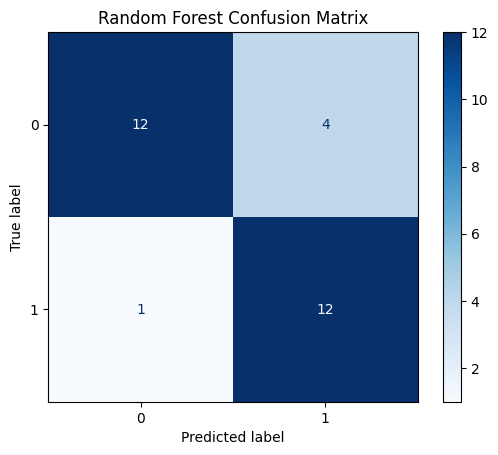

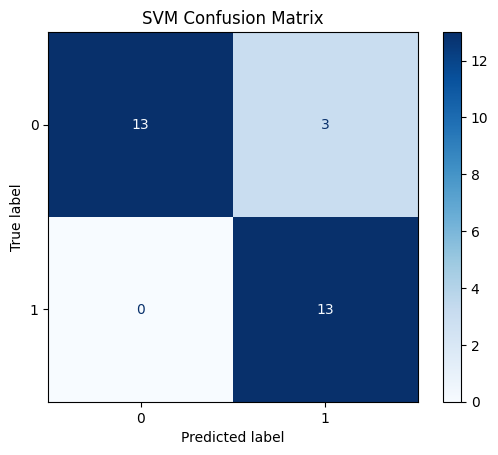

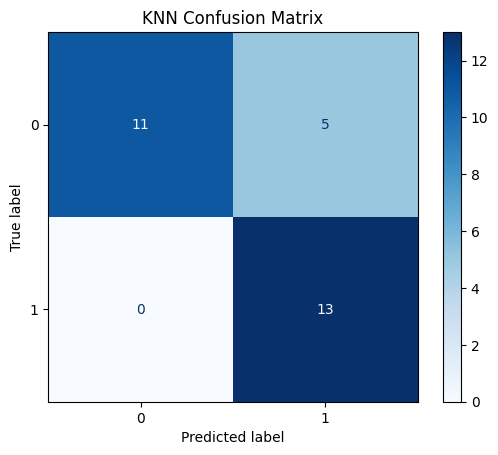

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")